# A US Federal Funding Cuts Visualisation

## Background 

On January 27, 2025, the Office of Management and Budget (OMB) issued a memorandum directing federal agencies to temporarily pause activities related to the obligation or disbursement of federal financial assistance in targeted areas such as foreign aid, diversity, equity, and inclusion (DEI) initiatives, and environmental projects. 

The OMB identified approximately 2,600 federal programs for review under this directive. While the freeze affects a significant number of programs, it does not encompass all federal programs. The targeted programs represent a portion of federal initiatives. 

## Aim

The aim of this project is to create a visualization that will shifts the focus from individual programs to thematic funding distribution within each department. Instead of looking at just programs, it highlights key themes/topics (words) that receive funding across multiple programs. This makes it easier to identify funding priorities and patterns within each department.

## Workflow

1. Extract the dataset from a txt file scrapped from the web, using a python script. Save as a *.csv file.
2. Data preparation in a notebook using python and scikit-learn. Export the data in JSON - an appropriate format to use in D3.js.
3. Data visualization using D3.js.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# to use regular expressions
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/us-federal-funding-cuts/processed_funding_data.csv")

Rename and convert to lower case all dataframe columns, for consistency:

In [3]:
df.rename(columns={"Name":"Program_Name"},inplace=True)
df.columns = map(str.lower, df.columns)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2596 entries, 0 to 2595
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   program_name  2596 non-null   object
 1   funding       2596 non-null   int64 
 2   department    2596 non-null   object
dtypes: int64(1), object(2)
memory usage: 61.0+ KB


In [5]:
print(f"There are {df['funding'].isna().sum()} null values in the 'Funding' column")

There are 0 null values in the 'Funding' column


In [6]:
print(f"There are {df['funding'].apply(lambda x: isinstance(x, str)).sum()} str values in the 'Funding' column")

There are 0 str values in the 'Funding' column


In [7]:
# Group program names by department into separate lists
df["total_department_funding"] = df.groupby("department")["funding"].transform("sum")

In [8]:
df.head()

,program_name,funding,department,total_department_funding
0,1890 Institution Capacity Building Grants,28000000,Department of Agriculture,234317786999
1,1994 Institutions Research Grants,5000000,Department of Agriculture,234317786999
2,2017 Wildfres and Hurricanes Indemnity Program,768000,Department of Agriculture,234317786999
3,Acer Access Development Program,8000000,Department of Agriculture,234317786999
4,Agricultural and Food Policy Research Centers,8000000,Department of Agriculture,234317786999


In [9]:
# Create a table of total funding per department, to export
departments_funding_df = df.groupby("department")["funding"].sum()

## WordCloud preparation

I will convert the text data into numerical features using the Bag-of-Words (BoW) model. It represents text as a collection of words, disregarding grammar and word order but keeping track of word frequency. This creates a one-hot encoding system with columns for each word in the bag of words.

Scikit-learn’s CountVectorizer(), will automatically convert the collection of texts in the 'program_name' column into a matrix of token counts. In it, each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix. The value of each cell is the count of the word in that particular text sample. Sparse matrices are memory-efficient, as they store only non-zero values.

I'll start by removing words that will not be useful in the word clouds, such as stop words. Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text.

### General funding stop words

In addition, out of the total words collected, we should remove words that would be meaningless to present in the world cloud. As these are federal programs receiving funding, so words would include 'grant','funding','program','loan','assistance', as they don't offer much insight. In addition, for each department, we should remove words for the department itself, e.g. 'agriculture' in the Department of Agriculture.

In [10]:
funding_stop_words = {
    "grant", "grants", "funding", "program", "programs", "loan", "loans", "assistance", "federal",
    "act", "initiative", "development", "authority", "support", "fund", "award", "allocation",
    "project", "projects", "plan", "plans", "service", "services", "administration", 
    "collaborative", "implementation", "management", "coordination", "resources", "opportunity",
    "partnership", "strategy", "technical", "capacity", "research", "innovation", "institution", "institutions",
    "policy", "policies", "center", "u.s.", "agency", "agencies", "america", "financing", "national", "office",
    "trust", "corporation", "promotion", "organization", "organizations", "commission", "investment", "investments",
    "relief", "institute", "incentive", "economic", "centers", "special", "offce", "state", "public", "state", "title",
    "demonstration", "wioa", "regional", "agreement", "cooperative", "american"
}

### Department-Specific Stop Words

Each department has its own redundant terms. These should be filtered only for that department so they don't affect others, so I'll create a dictionary to apply in each case:

In [11]:
department_stop_words = {
    "Department of Agriculture": {"agriculture", "agricultural", "farming", "farmers", "farm", "rural"},
    "Department of Commerce": {"commerce", "business", "trade", "economic"},
    "Department of Defense": {"defense", "military", "security", "forces"},
    "Department of Education": {"education", "schools", "students", "learning"},
    "Department of Energy": {"energy", "power", "renewable", "grid"},
    "Department of Health and Human Services": {"health", "human", "medical", "disease", "care"},
    "Department of Homeland Security": {"security", "homeland", "protection", "emergency"},
    "Department of Housing and Urban Development": {"housing", "urban", "development"},
    "Department of Justice": {"justice", "law", "criminal", "legal"},
    "Department of Labor": {"labor", "employment", "workforce", "wages"},
    "Department of State": {"state", "foreign", "international", "diplomacy"},
    "Department of Transportation": {"transportation", "infrastructure", "highways", "transit"},
    "Department of Veterans Affairs": {"veterans", "military", "benefits", "services", "veteran", "agreement"},
    "Department of the Treasury": {"treasury", "finance", "tax", "fiscal"}
}

Next, I'll define the preprocessor. The preprocessor will take each row of the dataframe, and a) remove whole numbers, b) remove numbers when provided inside the text, c) split the program names into words d) remove general funding stop words e) remove the stop words that are specific to that department and finally f) re-unite the words into one string.

In [12]:
# Convert Scikit-learn stop words to a set
english_stop_words = set(ENGLISH_STOP_WORDS)

I will also Lemmatization, to convert words to their dictionary base form (e.g., "education", "educational" → "education"), so they count towards one word.

In [13]:
import spacy

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Test if lemmatization works
doc = nlp("Educational programs provide funding for education.")
print([token.lemma_ for token in doc])  

['educational', 'program', 'provide', 'funding', 'for', 'education', '.']


In [14]:
"""
a) remove whole numbers
b) remove numbers when provided inside the text
c) split the program names into words
d) remove general funding stop words
e) remove the stop words that are specific to that department and finally
f) re-unite the words into one string

"""
def custom_preprocessor(text, department):
    """Removes numbers and department-specific stop words."""
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text)  
    text = re.sub(r'\d+', '', text)  
    words = text.split()

    # Process text with spaCy NLP pipeline
    doc = nlp(text)
    
    # Lemmatize words and remove stop words
    words = [token.lemma_ for token in doc if token.text not in funding_stop_words | english_stop_words]

    # Remove department-specific stop words
    if department in department_stop_words:
        words = [word for word in words if word not in department_stop_words[department]]

    return " ".join(words)

I will now apply the preprocessor to each row of the dataframe:

In [15]:
# Apply preprocessing before vectorization
df["cleaned_name"] = df.apply(lambda row: custom_preprocessor(row["program_name"], row["department"]), axis=1)

In [16]:
# df.iloc[250:300]

In [17]:
# Extract and groupby only the text column into a single text entry
words_per_department = df.groupby("department")["cleaned_name"].apply(lambda x: ' '.join(x))

And now I'll initiate the vectorizer:

In [18]:
vectorizer = CountVectorizer()

In [19]:
word_matrix = vectorizer.fit_transform(words_per_department)

In [20]:
type(word_matrix)

scipy.sparse._csr.csr_matrix

In [21]:
vectorizer.get_feature_names_out()

array(['abandon', 'abatement', 'ability', ..., 'zero', 'zone', 'zoonotic'],
      dtype=object)

We need to convert the matrix into a dataframe. The Dataframe() function takes series, arrays, constants, dataclass or list-like objects, so we need to first convert the sparse matrix into one:

In [22]:
# Convert sparse matrix into an array
word_matrix_array = word_matrix.toarray()

In [23]:
# Convert array into a dataframe
df_word_matrix = pd.DataFrame(data=word_matrix_array,
                             index=words_per_department.index,
                             columns=vectorizer.get_feature_names_out())

In [24]:
df_word_matrix.head()

,abandon,abatement,ability,able,abroad,abtc,abuse,aca,academia,academic,...,year,young,youth,youthbuild,yrbwe,yukon,zachary,zero,zone,zoonotic
department,,,,,,,,,,,,,,,,,,,,,
Department of Agriculture,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,0,0,0,0
Department of Commerce,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
Department of Defense,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
Department of Education,0,0,0,0,3,0,0,0,0,1,...,0,0,2,0,0,0,0,0,0,0
Department of Energy,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


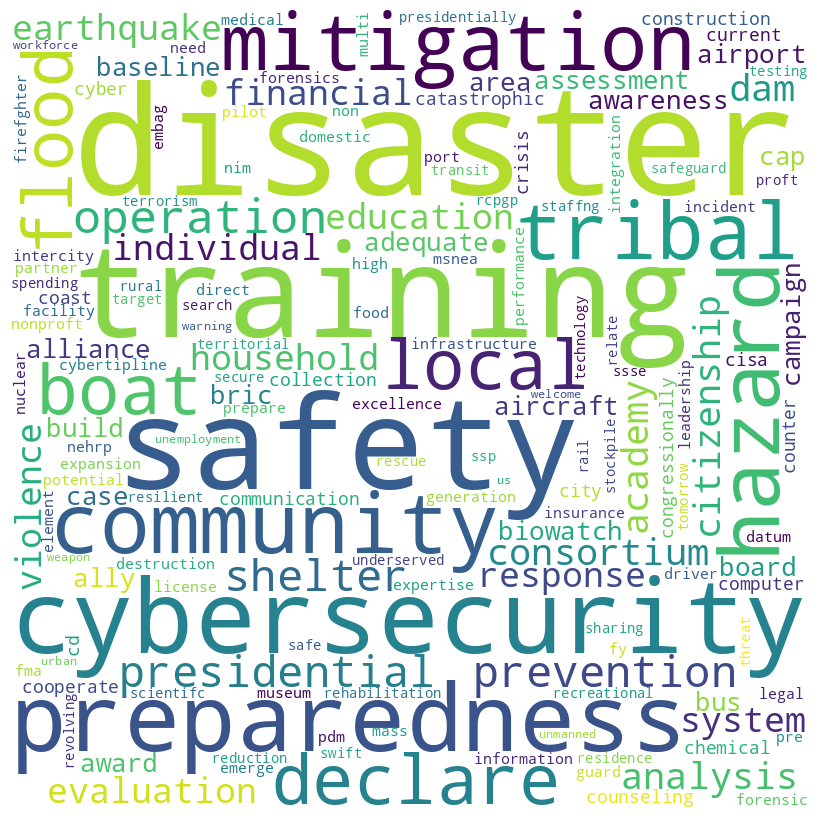

In [25]:
wordcloud = df_word_matrix.iloc[6]

wordcloud = wordcloud[wordcloud>0]

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(wordcloud)



# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [26]:
# Export total funding per department table
departments_funding_df.to_csv("departments_funding.csv")

# Export full word frequency table
df_word_matrix.to_csv("word_counts_by_department.csv")

# Export to JSON (for D3.js visualization)
df_word_matrix.to_json("word_counts_by_department.json", orient="index")